In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/added-object-list.txt
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/readme.txt
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/FudanPed00063_mask.png
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/FudanPed00028_mask.png
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/PennPed00051_mask.png
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/PennPed00004_mask.png
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/PennPed00035_mask.png
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/PennPed00037_mask.png
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks/PennPed00031_mask.png
/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPe

In [2]:
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_transform=None):
       
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.images = sorted(os.listdir(os.path.join(root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image and mask
        img_path = os.path.join(self.root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages", self.images[idx])
        mask_path = os.path.join(self.root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks", self.masks[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        # Convert mask to numpy and filter only pedestrian class
        mask = np.array(mask)
        mask[mask != 1] = 0  # Set all non-pedestrian pixels to 0 (background)
        mask = Image.fromarray(mask)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        
        mask = torch.as_tensor(np.array(mask), dtype=torch.uint8)  # Convert mask to tensor
        return image, mask

# Define transforms for images and masks
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),         # Convert images to tensors
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize masks
])

# Initialize dataset and dataloader
dataset = PennFudanDataset(
    root="./PennFudanPed", 
    transform=transform, 
    target_transform=target_transform
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Test the dataloader
for images, masks in dataloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break


Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 256, 256])


In [3]:
import os
import torch
from torchvision import transforms
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # Load only images; no masks will be used
        self.images = sorted(os.listdir(os.path.join(root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image
        img_path = os.path.join(self.root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages", self.images[idx])
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image

# Define transforms for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),         # Convert images to tensors
])

# Initialize dataset and dataloader
dataset = PennFudanDataset(
    root="./PennFudanPed", 
    transform=transform
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Save the output images
output_dir = "./processed_images_no_masks"
os.makedirs(output_dir, exist_ok=True)

for idx, image in enumerate(dataloader):
    # Convert the tensor back to PIL Image for saving
    image = transforms.ToPILImage()(image.squeeze(0))  # Remove batch dimension
    image.save(os.path.join(output_dir, f"image_{idx}.png"))
    print(f"Saved: image_{idx}.png")
    if idx == 5:  # Save only a few images for testing
        break


Saved: image_0.png
Saved: image_1.png
Saved: image_2.png
Saved: image_3.png
Saved: image_4.png
Saved: image_5.png


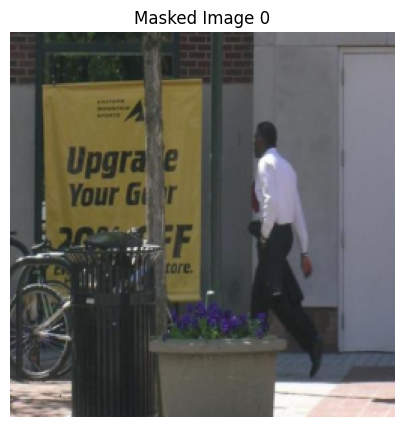

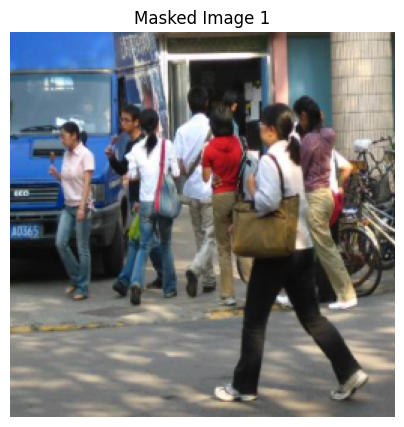

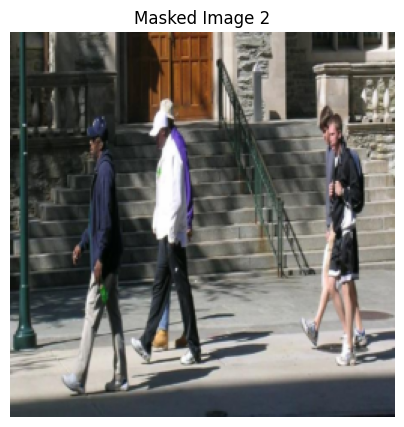

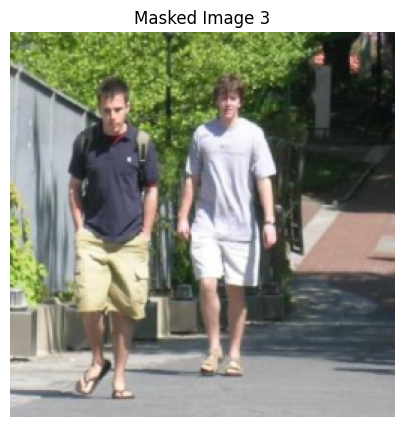

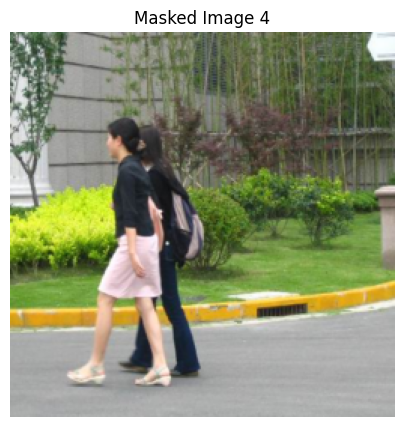

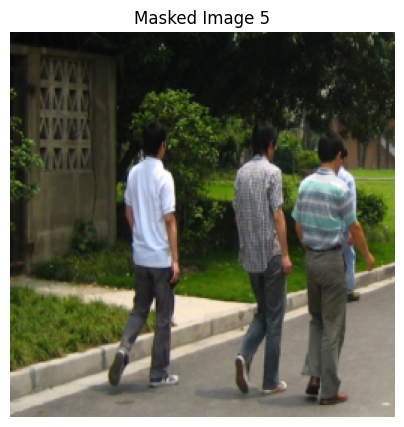

In [4]:
import matplotlib.pyplot as plt

# Visualize one batch of processed images
for idx, masked_image in enumerate(dataloader):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # Convert tensor to PIL Image for display
    image = transforms.ToPILImage()(masked_image.squeeze(0))  # Remove batch dimension

    # Display the masked image
    ax.imshow(image)
    ax.set_title(f"Masked Image {idx}")
    ax.axis("off")
    
    plt.show()
    if idx == 5:  # Visualize only the first few images
        break


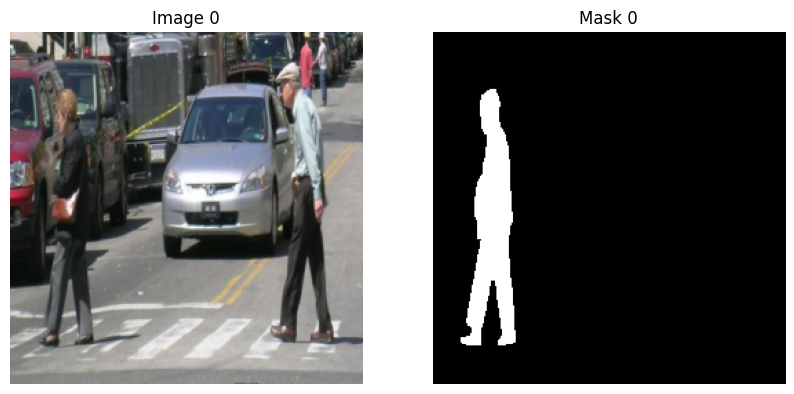

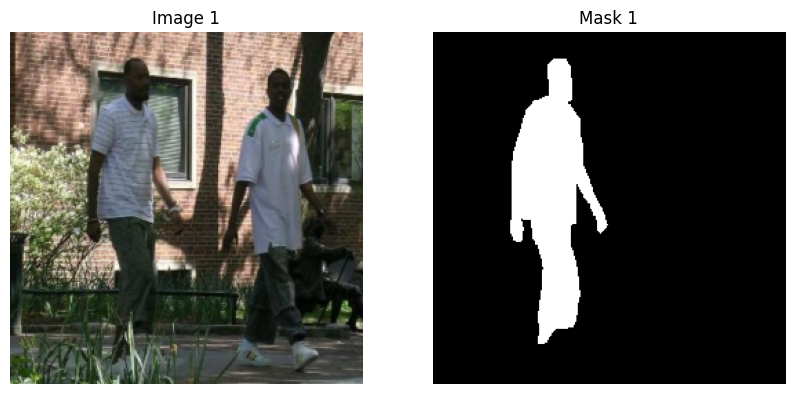

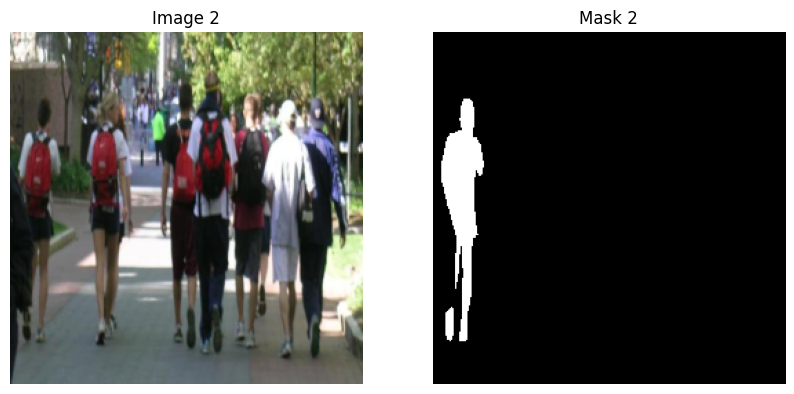

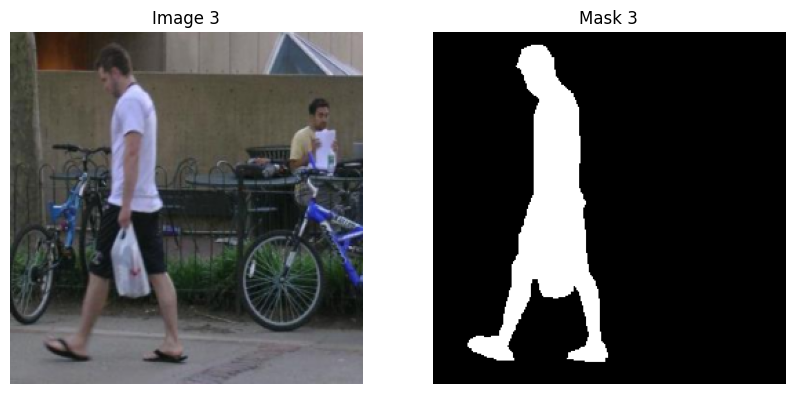

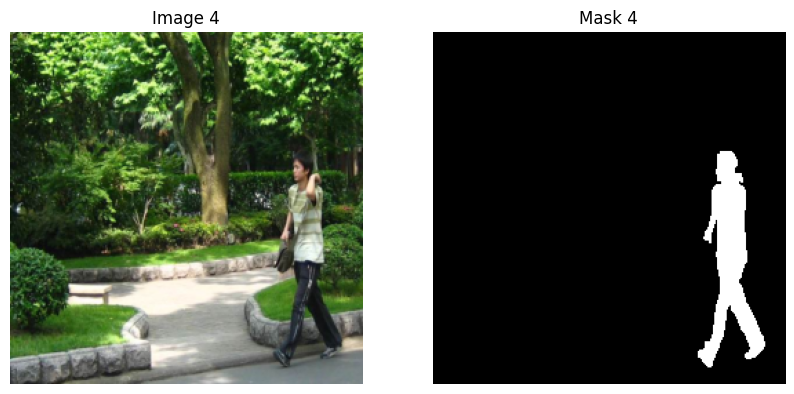

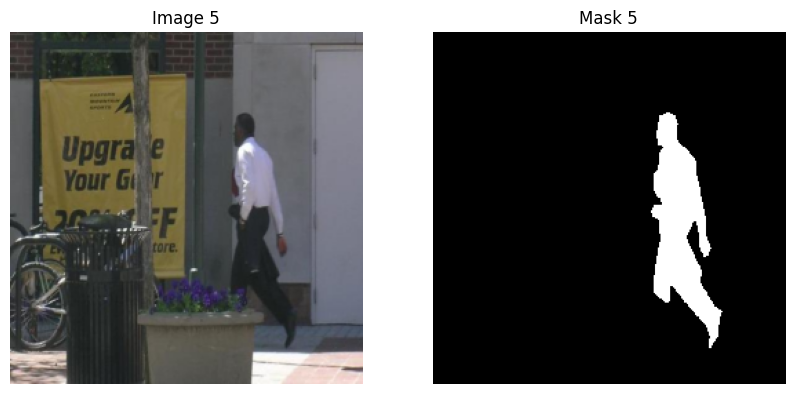

In [16]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        # Load images and masks
        self.images = sorted(os.listdir(os.path.join(root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get paths for the image and mask
        img_path = os.path.join(self.root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages", self.images[idx])
        mask_path = os.path.join(self.root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PedMasks", self.masks[idx])
        
        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        # Convert mask to numpy array and filter pedestrian pixels
        mask = np.array(mask)
        mask[mask != 1] = 0  # Set non-pedestrian pixels to 0 (background)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(Image.fromarray(mask))
        
        # Convert mask to tensor
        mask = torch.as_tensor(np.array(mask), dtype=torch.uint8)
        
        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),         # Convert images to tensors
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize masks
])

# Initialize dataset and dataloader
dataset = PennFudanDataset(
    root="./PennFudanPed", 
    transform=transform,
    target_transform=target_transform
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Visualization
for idx, (image, mask) in enumerate(dataloader):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Visualize the image
    ax[0].imshow(image[0].permute(1, 2, 0)) 
    ax[0].set_title(f"Image {idx}")
    ax[0].axis("off")
    
    # Visualize the mask
    ax[1].imshow(mask[0].numpy(), cmap="gray")
    ax[1].set_title(f"Mask {idx}")
    ax[1].axis("off")
    
    plt.show()
    if idx == 5:  # Display only a few samples
        break


In [5]:
import os
import torch
from torchvision import transforms
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # Load only images; no masks will be used
        self.images = sorted(os.listdir(os.path.join(root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the image
        img_path = os.path.join(self.root, "/kaggle/input/pennfudan-database-for-pedestrian-detection-zip/PennFudanPed/PNGImages", self.images[idx])
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image

# Define transforms for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),         # Convert images to tensors
])

# Initialize dataset and dataloader
dataset = PennFudanDataset(
    root="./PennFudanPed", 
    transform=transform
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Save the output images
output_dir = "./processed_images_no_masks"
os.makedirs(output_dir, exist_ok=True)

# Iterate through all images and save them
for idx, image in enumerate(dataloader):
    # Convert the tensor back to PIL Image for saving
    image = transforms.ToPILImage()(image.squeeze(0))  # Remove batch dimension
    image.save(os.path.join(output_dir, f"image_{idx}.png"))
    print(f"Saved: image_{idx}.png")


Saved: image_0.png
Saved: image_1.png
Saved: image_2.png
Saved: image_3.png
Saved: image_4.png
Saved: image_5.png
Saved: image_6.png
Saved: image_7.png
Saved: image_8.png
Saved: image_9.png
Saved: image_10.png
Saved: image_11.png
Saved: image_12.png
Saved: image_13.png
Saved: image_14.png
Saved: image_15.png
Saved: image_16.png
Saved: image_17.png
Saved: image_18.png
Saved: image_19.png
Saved: image_20.png
Saved: image_21.png
Saved: image_22.png
Saved: image_23.png
Saved: image_24.png
Saved: image_25.png
Saved: image_26.png
Saved: image_27.png
Saved: image_28.png
Saved: image_29.png
Saved: image_30.png
Saved: image_31.png
Saved: image_32.png
Saved: image_33.png
Saved: image_34.png
Saved: image_35.png
Saved: image_36.png
Saved: image_37.png
Saved: image_38.png
Saved: image_39.png
Saved: image_40.png
Saved: image_41.png
Saved: image_42.png
Saved: image_43.png
Saved: image_44.png
Saved: image_45.png
Saved: image_46.png
Saved: image_47.png
Saved: image_48.png
Saved: image_49.png
Saved: ima

In [6]:
import yaml

# Define YAML data
data = {
    'train': '/kaggle/working/PennFudanPed/PNGImages',
    'val': '/kaggle/working/PennFudanPed/PNGImages',
    'nc': 1,
    'names': ['pedestrian']
}

# Write to a YAML file
yaml_path = '/kaggle/working/penn_fudan.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"YAML file created at: {yaml_path}")


YAML file created at: /kaggle/working/penn_fudan.yaml


In [7]:
# Read and print the YAML file
with open('/kaggle/working/penn_fudan.yaml', 'r') as file:
    content = file.read()
    print(content)


names:
- pedestrian
nc: 1
train: /kaggle/working/PennFudanPed/PNGImages
val: /kaggle/working/PennFudanPed/PNGImages

